# Covid19 state-by-state analyses

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from cycler import cycler
from scipy import stats
import xarray as xr
from datetime import datetime
import itertools
import us
from numpy.lib.stride_tricks import as_strided as stride
import seaborn as sns

# Set plot size
matplotlib.style.use('seaborn-poster')
matplotlib.style.use('fivethirtyeight')
pd.plotting.register_matplotlib_converters()
sns.set_context('talk')

# Fetch population data

This lets us compute approximate per-capita values

In [2]:
population_url = 'http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv'
population_raw = pd.read_csv(population_url, error_bad_lines=False)

In [3]:
populations = population_raw.loc[:, ['NAME', 'POPESTIMATE2019']].set_index(['NAME'])
populations.index = populations.index.map(lambda idx: us.states.lookup(idx).abbr if us.states.lookup(idx) is not None else idx)

def lookup_population(abbr):
    return populations.loc[abbr][0]

def lookup_population_default(abbr):
    try:
        return lookup_population(abbr)
    except KeyError:
        return np.nan

### Australian population data

Unfortunately this has to be loaded from disk rather than fetched from the internet.  The ABS website is so hilariously clunky and manual that you can't even reuse a download link for the CSV corresponding to the default view (exactly what we want -- quarterly state populations) when the page loads.  It also displays a helpful warning that you had better use Internet Explorer to view the website.  Amazing.

Anyway, if you want to run this, please visit [this incredible website](http://stat.data.abs.gov.au/Index.aspx?DataSetCode=ERP_QUARTERLY) and click "Export" at the top left of the table.  You may also need to change the filename that's loaded; I have no idea whether these are deterministic given the view, but something tells me they're not.

In [4]:
aus_populations_raw = pd.read_csv('ERP_QUARTERLY_27112020173117964.csv')
aus_population_data = ((aus_populations_raw[aus_populations_raw['Measure'] == 'Estimated Resident Population']
                                       [aus_populations_raw['Time'] == 'Mar-2020']
                                       [aus_populations_raw['Sex'] == 'Persons'])
                    .loc[:, ['State', 'Value']]
                    .set_index('State')
                    .rename(index={
     'Queensland':'QLD',
     'Tasmania':'TAS',
     'Northern Territory':'NT',
     'South Australia':'SA',
     'Western Australia':'WA',
     'Australian Capital Territory':'ACT',
     'New South Wales':'NSW',
     'Victoria':'VIC',
     'Australia':'AU',
 }))

def lookup_aus_population(abbr):
    return aus_population_data.loc[abbr][0]

def lookup_aus_population_default(abbr):
    try:
        return lookup_aus_population(abbr)
    except KeyError:
        return np.nan
    
lookup_aus_population_default('ACT')

<ipython-input-4-12b13b355ade>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aus_population_data = ((aus_populations_raw[aus_populations_raw['Measure'] == 'Estimated Resident Population']


429834.0

## Fetch the latest data on the epidemic

Not everything we want is filled in, but this seems like as good an authoritative source as any

In [5]:
states_daily_url = 'http://covidtracking.com/api/states/daily.csv'
us_daily_url = 'http://covidtracking.com/api/us/daily.csv'

states_daily = pd.read_csv(states_daily_url, error_bad_lines=False)
us_daily = pd.read_csv(us_daily_url, error_bad_lines=False)

## Looking at the raw data

In [6]:
non_numeric_column_names = ['date', 'state', 'hash', 'dateChecked']
date_column_names = ['date', 'dateChecked']
numeric_idx = [x for x in states_daily.columns if x not in non_numeric_column_names] 

## Organizing the data

We use the `xarray` to organize this data into a normalized form for easier post-processing and analysis.  The function `create_multi_indexed_data` produces an `xarray.Dataset` using the raw data, to which we will later append additional intermediate results as we compute them.

This function is mega-slow, but oh well.  We only run it once per data set ahead of time; all the post-processing can happen subsequently.

In [7]:
def create_multi_indexed_data(df, datekw='date', statekw='state', datefmt='%Y%m%d'):
    special_column_names = [datekw, statekw]
    dates = df.loc[:, datekw].unique()
    states = df.loc[:, statekw].unique()
    nested_idx = pd.MultiIndex.from_product([dates, states], names=special_column_names)
    def match_with_default(date, state):
        try:
            return df.loc[(df.loc[:, datekw] == date) & (df.loc[:, statekw] == state), :].set_index(special_column_names)
        except KeyError:
            new_index = pd.MultiIndex.from_tuples([(date, state)], names=special_column_names)
            return pd.DataFrame(np.nan, index=0, columns=df.columns).set_index(new_index)
    new = pd.concat([match_with_default(date, state) for date, state in nested_idx])
    new.index = new.index.set_levels([pd.to_datetime(new.index.levels[0], format=datefmt, errors='raise'), 
                                     new.index.levels[1].astype(str)])
    new = new.loc[~new.index.duplicated(keep='last')]
    new = new.sort_index(level=datekw)
    return xr.Dataset.from_dataframe(new)

### Additional analysis

We're interested in looking at a number of derived quantities.  To make it easier to plot interactively, we compute these quantities and add them to the `xarray.Dataset` as we go.  This separates all the calculations from the plotting.

Derived quantities include

 - test result rates (i.e. fraction of tests that came back positive)
 - various per-capita versions of raw data
 - time-domain smoothed data

In [8]:
def compute_rates(df, rate_vars=['positive'], totalkw='totalTestResults'):
    for var in rate_vars:
        df[f'{var}_rate'] = df[var] / df[totalkw]
        df[f'incremental_{var}_rate'] = df[f'{var}Increase'] / df[f'{totalkw}Increase']
    return df

def compute_population_table(df, lookup_f):
    state_index = df.state.to_index()
    date_index = df.date.to_index()
    state_populations = pd.DataFrame([lookup_f(abbr) for abbr in df['positive'].state.to_index()],
                                     index=df['positive'].state.to_index().astype(object), 
                                     columns=['population'])
    state_populations = pd.concat([state_populations] * len(date_index), axis=1)
    state_populations.columns = date_index
    return state_populations

def per_capitify(df, pc_vars, populations):
    for var in pc_vars:
        df[f'{var}_per_capita'] = df[var] / populations
    return df

#### Time-domain smoothing

Smoothing is particularly important to the US dataset, because there's a tremendous amount of variation dependent on the day of the week.  Either many states can't get their bookkeeping together or mysteriously the virus kills half as many people on Sundays.

In [9]:
def compute_smoothed(df, to_smooth, window_size=3):
    return (df[to_smooth]
            .rolling(date=window_size, center=True)
            .construct('window')
            .reduce(func=np.nanmean, dim='window')
            .rename_vars({x : f'{x}_{window_size}_day_smoothed' for x in to_smooth}))

# Post-processing

## US calculations

Here we compute all the derived data for the US.

In [10]:
states = create_multi_indexed_data(states_daily)
states = compute_rates(states)

us_per_capita_values = ['positive', 'negative', 'pending', 'hospitalized', 'death',
                             'total', 'totalTestResults',
                             'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 
                             'positiveIncrease', 'totalTestResultsIncrease', 'positive_rate', 
                             'incremental_positive_rate', 'inIcuCurrently', 'hospitalizedCurrently',
                            ]

us_populations = compute_population_table(states, lookup_population_default).transpose()

states = per_capitify(states, us_per_capita_values, us_populations)
vars_to_smooth = ['positiveIncrease', 'negativeIncrease', 'totalTestResultsIncrease',
                  'hospitalizedIncrease', 'deathIncrease', 'positive_rate', 'hospitalized',
                  'incremental_positive_rate', 'inIcuCurrently', 'hospitalizedCurrently',]
vars_to_smooth_per_capita = [f'{x}_per_capita' for x in vars_to_smooth]
smoothed = compute_smoothed(states, vars_to_smooth + vars_to_smooth_per_capita, window_size=7)
states = xr.combine_by_coords([states, smoothed])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [11]:
states

<xarray.Dataset>
Dimensions:                                              (date: 310, state: 56)
Coordinates:
  * date                                                 (date) datetime64[ns] ...
  * state                                                (state) object 'AK' ...
Data variables:
    positive                                             (date, state) float64 ...
    probableCases                                        (date, state) float64 ...
    negative                                             (date, state) float64 ...
    pending                                              (date, state) float64 ...
    totalTestResultsSource                               (date, state) object ...
    totalTestResults                                     (date, state) float64 ...
    hospitalizedCurrently                                (date, state) float64 ...
    hospitalizedCumulative                               (date, state) float64 ...
    inIcuCurrently                                       (date, state) float64 ...
    inIcuCumulative                                      (date, state) float64 ...
    onVentilatorCurrently                                (date, state) float64 ...
    onVentilatorCumulative                               (date, state) float64 ...
    recovered                                            (date, state) float64 ...
    dataQualityGrade                                     (date, state) object ...
    lastUpdateEt                                         (date, state) object ...
    dateModified                                         (date, state) object ...
    checkTimeEt                                          (date, state) object ...
    death                                                (date, state) float64 ...
    hospitalized                                         (date, state) float64 ...
    dateChecked                                          (date, state) object ...
    totalTestsViral                                      (date, state) float64 ...
    positiveTestsViral                                   (date, state) float64 ...
    negativeTestsViral                                   (date, state) float64 ...
    positiveCasesViral                                   (date, state) float64 ...
    deathConfirmed                                       (date, state) float64 ...
    deathProbable                                        (date, state) float64 ...
    totalTestEncountersViral                             (date, state) float64 ...
    totalTestsPeopleViral                                (date, state) float64 ...
    totalTestsAntibody                                   (date, state) float64 ...
    positiveTestsAntibody                                (date, state) float64 ...
    negativeTestsAntibody                                (date, state) float64 ...
    totalTestsPeopleAntibody                             (date, state) float64 ...
    positiveTestsPeopleAntibody                          (date, state) float64 ...
    negativeTestsPeopleAntibody                          (date, state) float64 ...
    totalTestsPeopleAntigen                              (date, state) float64 ...
    positiveTestsPeopleAntigen                           (date, state) float64 ...
    totalTestsAntigen                                    (date, state) float64 ...
    positiveTestsAntigen                                 (date, state) float64 ...
    fips                                                 (date, state) float64 ...
    positiveIncrease                                     (date, state) float64 ...
    negativeIncrease                                     (date, state) float64 ...
    total                                                (date, state) float64 ...
    totalTestResultsIncrease                             (date, state) float64 ...
    posNeg                                               (date, state) float64 ...
    deathIncrease                                        (date, 

## Australian calculations

Data comes from Guardian Australia [here](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/mar/30/coronavirus-cases-in-australia-map-confirmed-numbers-stats-how-many-cases-of-covid-19-nsw-maps-victoria-live-data-qld-sa-wa-tas-nt-latest-statistics-update):

> This database is available for re-use under a Creative Commons Attribution 3.0 Australia (CC BY 3.0 AU) licence, which means it is OK to re-use, but please provide attribution and a link to Guardian Australia. 

In [12]:
aus_states_raw = pd.read_json('https://interactive.guim.co.uk/docsdata/1q5gdePANXci8enuiS4oHUJxcxC13d6bjMRSicakychE.json')

In [13]:
aus_states_mapping = {
    'Cumulative case count' : 'positive',
    'Cumulative deaths' : 'death',
    'Tests conducted (negative)' : 'negative',
    'Tests conducted (total)' : 'totalTestResults',
    'Intensive care (count)' : 'inIcuCurrently',
    'Hospitalisations (count)' : 'hospitalizedCurrently',
    'Recovered (cumulative)' : 'recovered',
}
aus_state_times = ['Time']
aus_state_numeric = [
    'Cumulative case count',
    'Cumulative deaths',
    'Tests conducted (negative)',
    'Tests conducted (total)',
    'Intensive care (count)',
    'Hospitalisations (count)',
    'Recovered (cumulative)',
]

aus_states_daily = pd.json_normalize(aus_states_raw.loc['updates']['sheets'])
aus_states_daily.loc[:, aus_state_numeric] = (aus_states_daily
                                              .loc[:, aus_state_numeric]
                                              .replace({' ':np.nan})
                                              .replace({',':''}, regex=True)
                                              .apply(pd.to_numeric))
aus_states_daily = aus_states_daily.rename(columns={'Date':'date', 'State':'state'})
aus_state_numeric = [aus_states_mapping[k] for k in aus_state_numeric]

We have to compute our own day-by-day values.  As defined, these values can never decrease, but the actual dataset contains various instances where a cumulative measurement decreases from day to day.  To keep things simple, we just mask out the various bookkeeping errors that seem to be present in the data.  This is done both to the deltas and to the original (cumulative) values.

In [14]:
aus_states = create_multi_indexed_data(aus_states_daily, 
                                       datefmt='%d/%m/%Y')
aus_states = aus_states.rename_vars(aus_states_mapping)
for var in aus_state_numeric:
    aus_states[var] = aus_states[var].astype(np.float64)

aus_compute_deltas = ['totalTestResults', 'positive', 'death', 'negative', 'recovered']
for cum in aus_compute_deltas:
    inc = f'{cum}Increase'
    aus_states[inc] = xr.DataArray(pd.DataFrame(np.diff(aus_states[cum]
                                                .to_dataframe()
                                                .unstack(level='state')
                                                .to_numpy(), 
                                                axis=0, 
                                                prepend=0),
                                   index=aus_states.coords['date'].to_series(),
                                   columns=aus_states.coords['state'].to_series()),
             coords=aus_states.coords)
    aus_states[inc] = aus_states[inc].where(aus_states[inc] >= 0)
    aus_states[cum] = aus_states[cum].where(aus_states[inc] >= 0)
    
aus_states = compute_rates(aus_states)
aus_per_capita_values = ['positive', 'negative', 'hospitalizedCurrently', 'death',
                         'totalTestResults',
                         'deathIncrease', 'negativeIncrease', 
                         'positiveIncrease', 'totalTestResultsIncrease', 'positive_rate', 
                         'incremental_positive_rate', 'inIcuCurrently',
                        ]

aus_populations = compute_population_table(aus_states, lookup_aus_population_default).transpose()
aus_states = per_capitify(aus_states, aus_per_capita_values, aus_populations)
aus_vars_to_smooth = ['positiveIncrease', 'negativeIncrease', 'totalTestResultsIncrease',
                     'deathIncrease', 'positive_rate', 
                      'incremental_positive_rate', 'inIcuCurrently', 'hospitalizedCurrently']
aus_vars_to_smooth_per_capita = [f'{var}_per_capita' for var in aus_vars_to_smooth]
# Smooth Aus less because the data are more spotty but have a lot less variation across the week
aus_smoothed = compute_smoothed(aus_states, aus_vars_to_smooth + aus_vars_to_smooth_per_capita, window_size=7)
aus_states = xr.combine_by_coords([aus_states, aus_smoothed])

In [15]:
aus_states

<xarray.Dataset>
Dimensions:                                              (date: 302, state: 8)
Coordinates:
  * date                                                 (date) datetime64[ns] ...
  * state                                                (state) object 'ACT'...
Data variables:
    Time                                                 (date, state) object ...
    positive                                             (date, state) float64 ...
    death                                                (date, state) float64 ...
    negative                                             (date, state) float64 ...
    totalTestResults                                     (date, state) float64 ...
    hospitalizedCurrently                                (date, state) float64 ...
    inIcuCurrently                                       (date, state) float64 ...
    Ventilator usage (count)                             (date, state) object ...
    recovered                                            (date, state) float64 ...
    Update Source                                        (date, state) object ...
    Notes                                                (date, state) object ...
    totalTestResultsIncrease                             (date, state) float64 ...
    positiveIncrease                                     (date, state) float64 ...
    deathIncrease                                        (date, state) float64 ...
    negativeIncrease                                     (date, state) float64 ...
    recoveredIncrease                                    (date, state) float64 ...
    positive_rate                                        (date, state) float64 ...
    incremental_positive_rate                            (date, state) float64 ...
    positive_per_capita                                  (date, state) float64 ...
    negative_per_capita                                  (date, state) float64 ...
    hospitalizedCurrently_per_capita                     (date, state) float64 ...
    death_per_capita                                     (date, state) float64 ...
    totalTestResults_per_capita                          (date, state) float64 ...
    deathIncrease_per_capita                             (date, state) float64 ...
    negativeIncrease_per_capita                          (date, state) float64 ...
    positiveIncrease_per_capita                          (date, state) float64 ...
    totalTestResultsIncrease_per_capita                  (date, state) float64 ...
    positive_rate_per_capita                             (date, state) float64 ...
    incremental_positive_rate_per_capita                 (date, state) float64 ...
    inIcuCurrently_per_capita                            (date, state) float64 ...
    positiveIncrease_7_day_smoothed                      (date, state) float64 ...
    negativeIncrease_7_day_smoothed                      (date, state) float64 ...
    totalTestResultsIncrease_7_day_smoothed              (date, state) float64 ...
    deathIncrease_7_day_smoothed                         (date, state) float64 ...
    positive_rate_7_day_smoothed                         (date, state) float64 ...
    incremental_positive_rate_7_day_smoothed             (date, state) float64 ...
    inIcuCurrently_7_day_smoothed                        (date, state) float64 ...
    hospitalizedCurrently_7_day_smoothed                 (date, state) float64 ...
    positiveIncrease_per_capita_7_day_smoothed           (date, state) float64 ...
    negativeIncrease_per_capita_7_day_smoothed           (date, state) float64 ...
    totalTestResultsIncrease_per_capita_7_day_smoothed   (date, state) float64 ...
    deathIncrease_per_capita_7_day_smoothed              (date, state) float64 ...
    positive_rate_per_capita_7_day_smoothed              (date, state) float64 ...
    incremental_positive_rate_per_capita_7_day_smoothed  (date, state) float64 ...
    inIcuCurrently_per_capita_7_day_smoothed             (date,

In [16]:
combined_states = states.combine_first(aus_states)
combined_states['totalTestResultsIncrease_per_capita'].loc[:, 'NSW']
aus_populations

state,ACT,NSW,NT,QLD,SA,TAS,VIC,WA
date,,,,,,,,
2020-01-23,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-01-25,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-01-27,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-01-28,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-01-29,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
...,...,...,...,...,...,...,...,...
2020-11-20,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-11-21,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0
2020-11-22,429834.0,8157735.0,245353.0,5160023.0,1767247.0,539590.0,6689377.0,2656156.0


In [24]:
def plot_variable(axis, da, varname, plot_states, plot_log, datekw, statekw, **kwargs):
    for state_name in plot_states:
        axis.plot(da.coords[datekw], da.loc[:, state_name], label=f'{state_name}', **kwargs)
    axis.grid(True)
    axis.set_ylabel(f'{varname}')
    if plot_log:
        axis.set_yscale('log')
    
def better_comparison_plot(df, plot_states, plot_vars, 
                           figwidth=15, plot_log=True, datekw='date', statekw='state', 
                           **kwargs):
    num_vars = len(plot_vars)
    fig = plt.figure(figsize=(figwidth, 6 * num_vars))
    fig.set_tight_layout(True)
    gs = gridspec.GridSpec(num_vars, 1)
    first_axis = plt.subplot(gs[0])
    ## For some mysterious matplotlib reason, the following 4 lines
    ## have no effect whatsoever on the resulting plot.
    # first_axis.xaxis.set_ticks_position('top')
    # first_axis.xaxis.tick_top()
    # first_axis.xaxis.set_label_position('top')
    # first_axis.set_xlabel(f'{datekw}')
    last_axis = plt.subplot(gs[-1])
    for axis_idx, varname in enumerate(plot_vars):
        last = axis_idx == num_vars - 1
        first = axis_idx == 0
        axis = plt.subplot(gs[axis_idx], sharex=last_axis) if not last else last_axis
        axis.set_prop_cycle(color=matplotlib.cm.get_cmap('tab10').colors)
        plot_variable(axis, df[varname], varname, plot_states, plot_log, datekw, statekw, **kwargs)
        ## If the block of code above mysteriously begins to function again,
        ## we may need to leave the tick labels around for the first axis.
        if not last:  # and not first:
            plt.setp(axis.get_xticklabels(), visible=False)
        if axis_idx % 2 == 0:
            axis.legend()

    last_axis.set_xlabel(f'{datekw}')
    for tick in last_axis.get_xticklabels():
        tick.set_rotation(22)
        
    plt.tight_layout()
    plt.show()

### Understanding the testing situation

I find most reports on the covid-19 situation tend to just say "n new cases" without providing any context.  But as the MCMC work in April showed and the following plots confirm, that number is not super meaningful without understanding the testing environment, which seems to vary dramatically by location.  Anecdotally, tests in Brisbane are free and return results within 24 hours, whereas in the US they may or may not be covered by insurance and may take 3-5 days to come back with a result.

`test_rate_plot()` produces a plot of the state's testing trajectory over time: the x-axis is the total number of tests conducted, and the y-axis is the number of tests that returned positive.  Each state gets a data point per day with the relevant daily numbers; dates are color-coded, so you can see upward bends as flare-ups occur and downward bends as testing catches up.  This plot does not tell you how bad the covid-19 situation is in a state; it tells you how bad the covid-19 testing situation is.  The slope of the trajectory at each day is obviously the test positive rate for that day.

In [25]:
def test_rate_plot(df, states, datekw='date', 
                   intotalkw='totalTestResultsIncrease', inposkw='positiveIncrease',
                   per_capita=False,
                   startDate=None, label_series=True):
    from matplotlib.dates import DateFormatter, DayLocator, date2num
    fig, ax = plt.subplots(figsize=(15, 15))
    markers = itertools.cycle(('+', 'o', '*', 'v', '$L$', 'x', '>', '1', 'p', 's', '4', 'd', '$g$'))
    totalkw = intotalkw
    poskw = inposkw
    q = 'tests'
    if per_capita:
        totalkw = f'{totalkw}_per_capita'
        poskw = f'{poskw}_per_capita'
        q = f'{q} per capita'
    for state in states:
        # Since we compute the daily deltas by subtracting ourselves, accounting errors
        # in the original data can lead to negative deltas.  We clamp them to zero since 
        # mainly they distract from the plot.
        xdata = np.cumsum(df[totalkw].loc[:, state].clip(min=0))
        ydata = np.cumsum(df[poskw].loc[:, state].clip(min=0))
        smap = ax.scatter(xdata,
                          ydata,
                          c=[date2num(i.date()) for i in df.coords[datekw].to_series()],
                          cmap='winter',
                          label=f'{state}',
                          marker=next(markers))
        if label_series:
            ax.annotate(state, xy=(np.max(xdata), np.max(ydata)),
                        verticalalignment='bottom', horizontalalignment='left')
    date0 = df.coords[datekw].to_series()[0] if startDate is None else startDate
    date1 = df.coords[datekw].to_series()[-1]
    fig.colorbar(smap, format=DateFormatter('%d %b'), ticks=DayLocator(interval=3))    

    # Note that we cannot support log-plotting due to some ridiculous issue with matplotlib.
    #
    # Moving `set_xscale('log')` and `set_yscale('log')` before the call to `scatter()` does not work.
    # Setting the x and y limits using the data does not work either.
    #
    # https://github.com/matplotlib/matplotlib/issues/7413 offers a fascinating view into the
    # matplotlib team's approach to constructing software.
    states_formatted = ', '.join([str(s) for s in states])
    ax.set_title(f'Daily tests for {states_formatted} from {date0.date()} to {date1.date()}')
    ax.set_xlabel(f'Total {q}')
    ax.set_ylabel(f'Positive {q}')
    ax.legend()

In [26]:
def drop_before(df, start_date):
    return df.where(df['date'] >= np.datetime64(datetime.strptime(start_date, '%Y-%m-%d')),
                    drop=True)
start_date = '2020-09-01'
recent_states = drop_before(states, start_date)
aus_recent_states = drop_before(aus_states, '2020-07-01')
combined_recent_states = drop_before(combined_states, '2020-07-01')

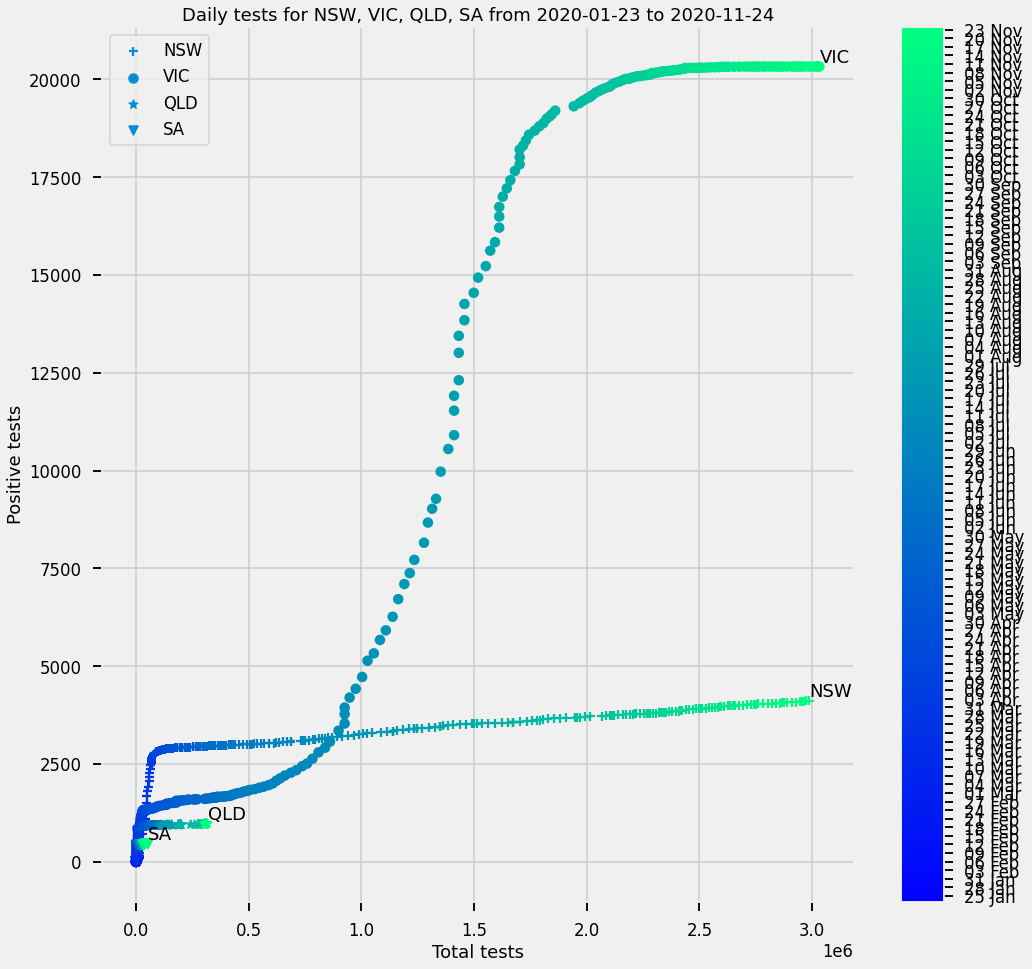

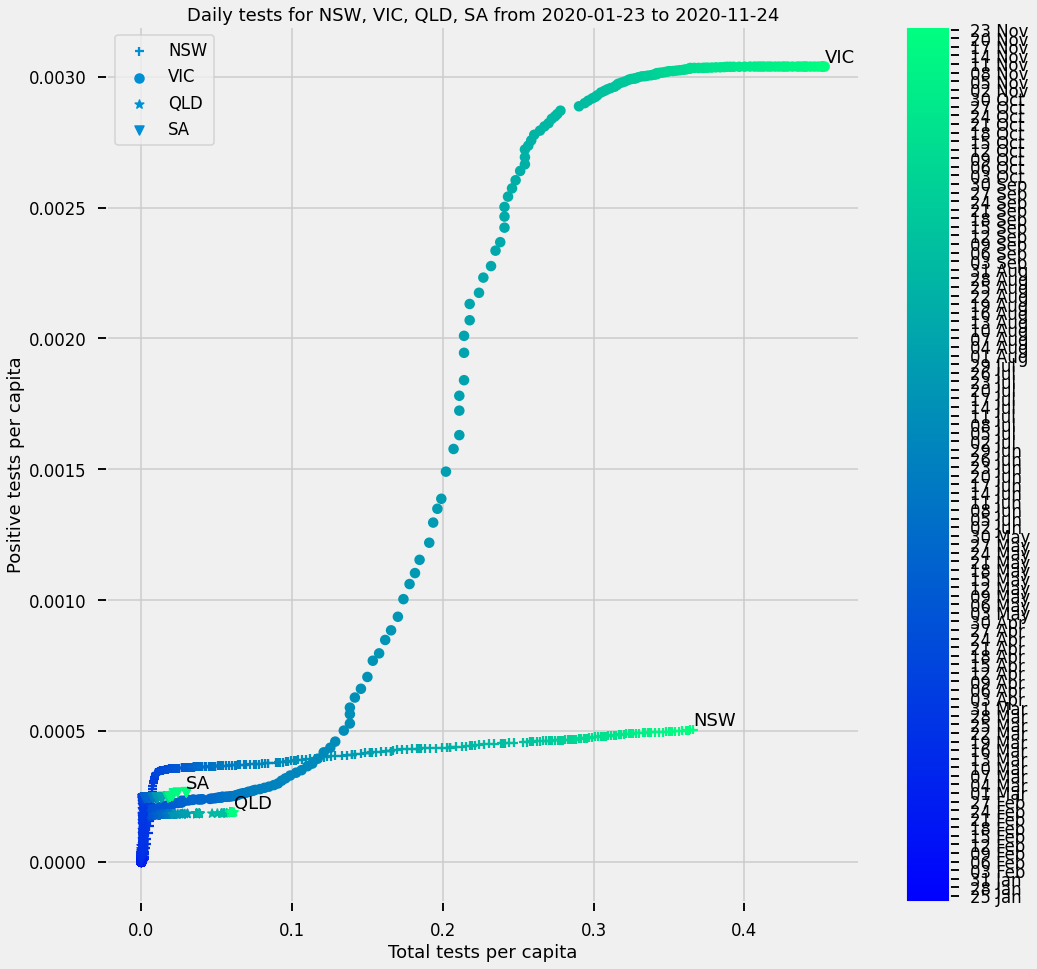

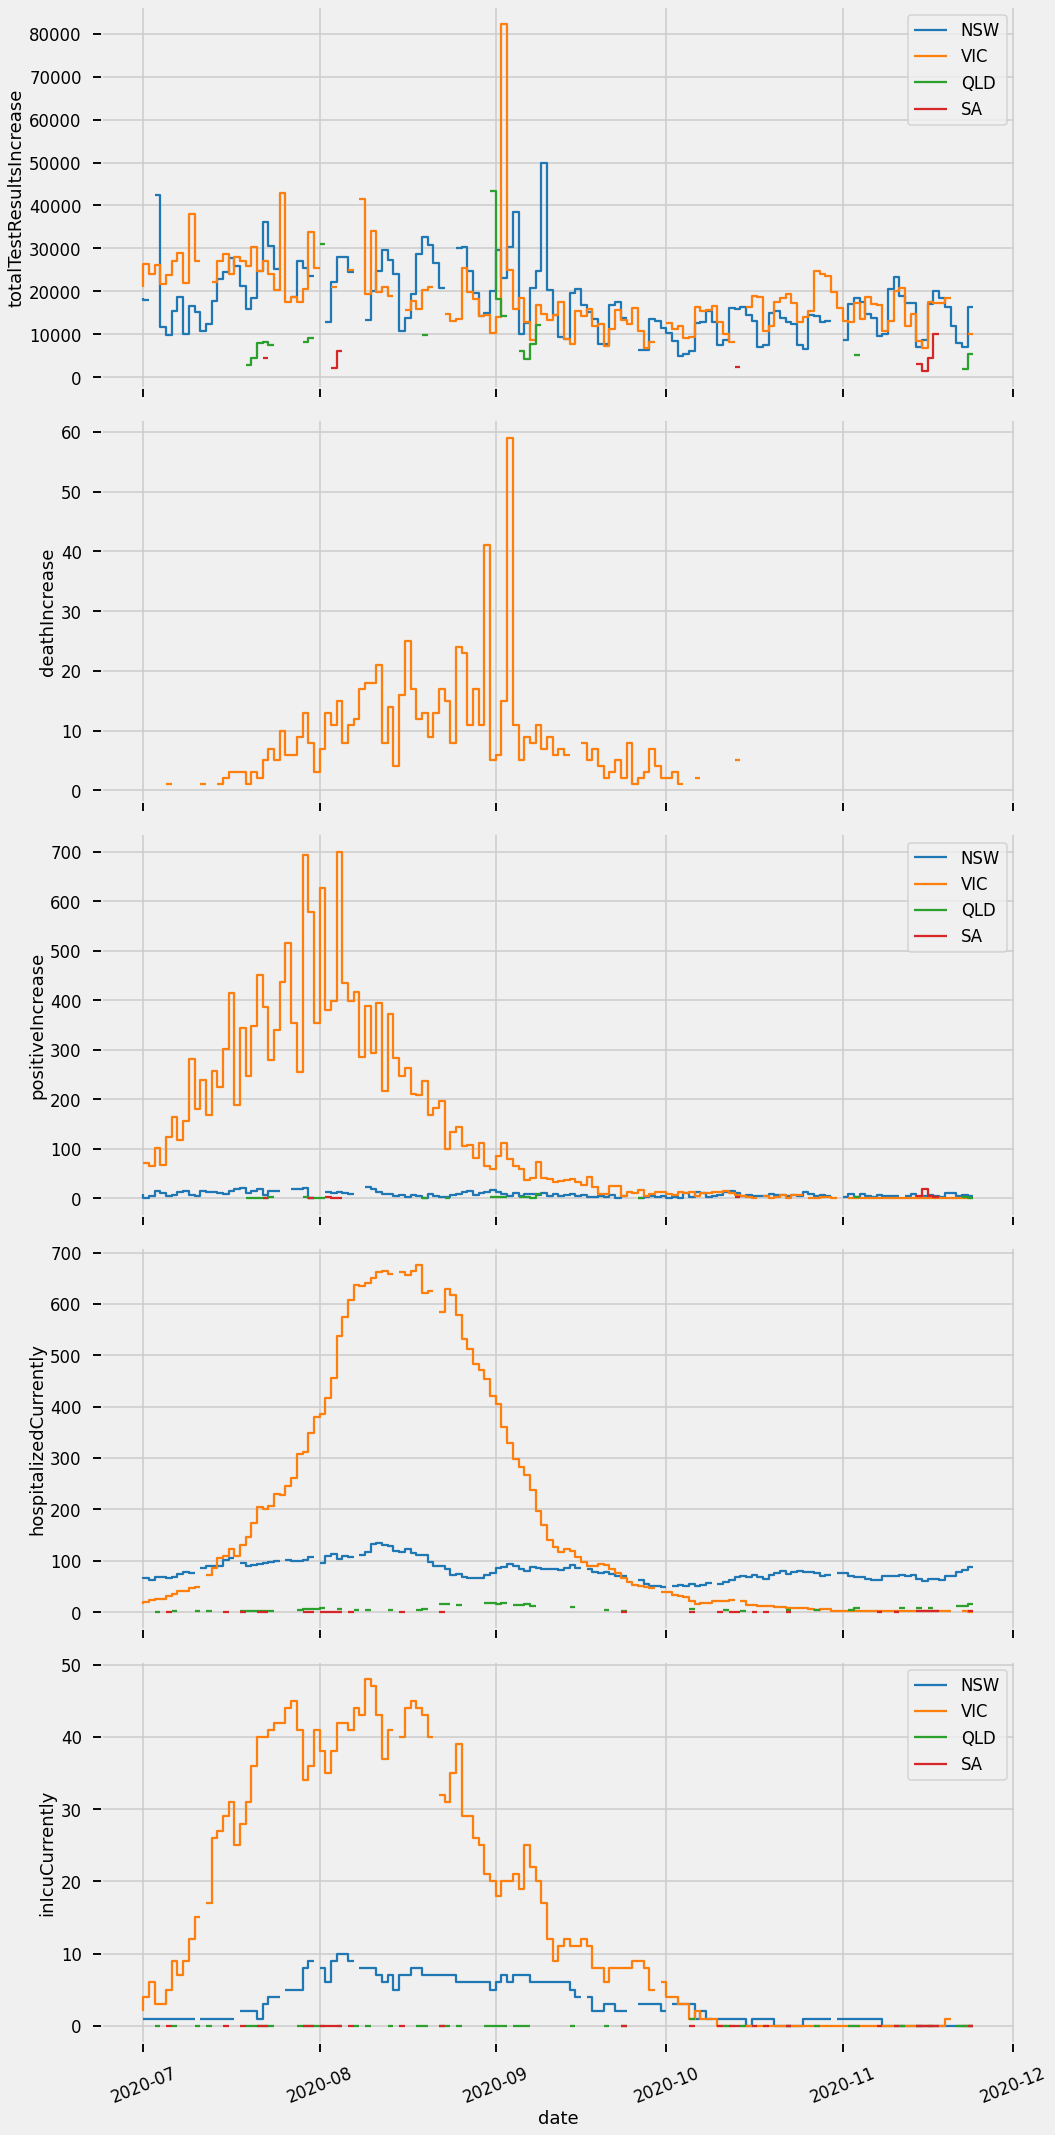

In [27]:
aus_states_plot = ['NSW', 'VIC', 'QLD', 'SA']
test_rate_plot(aus_states, aus_states_plot)
test_rate_plot(aus_states, aus_states_plot, per_capita=True)
aus_vars_plot = ['totalTestResultsIncrease', 'deathIncrease', 'positiveIncrease', 'hospitalizedCurrently', 'inIcuCurrently']
better_comparison_plot(aus_recent_states, 
                aus_states_plot, 
                aus_vars_plot,
                plot_log=False,
                drawstyle='steps')

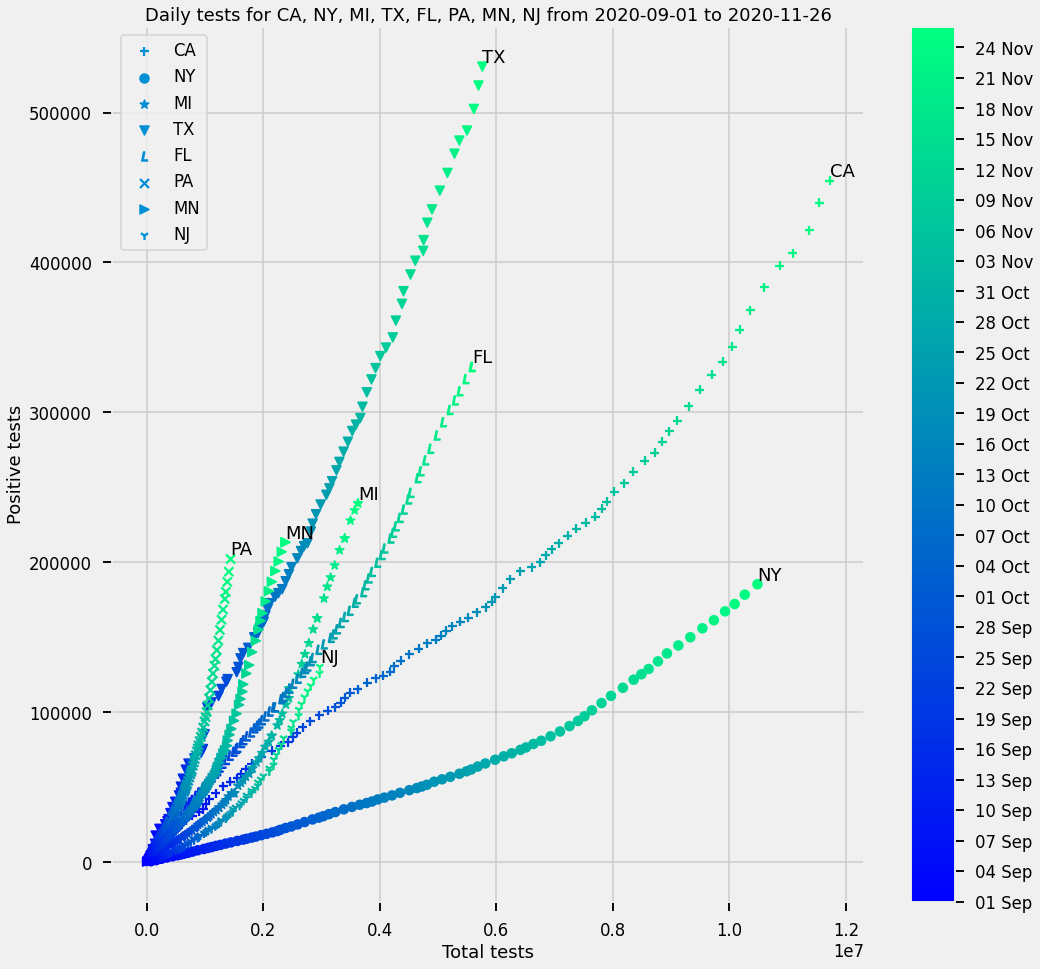

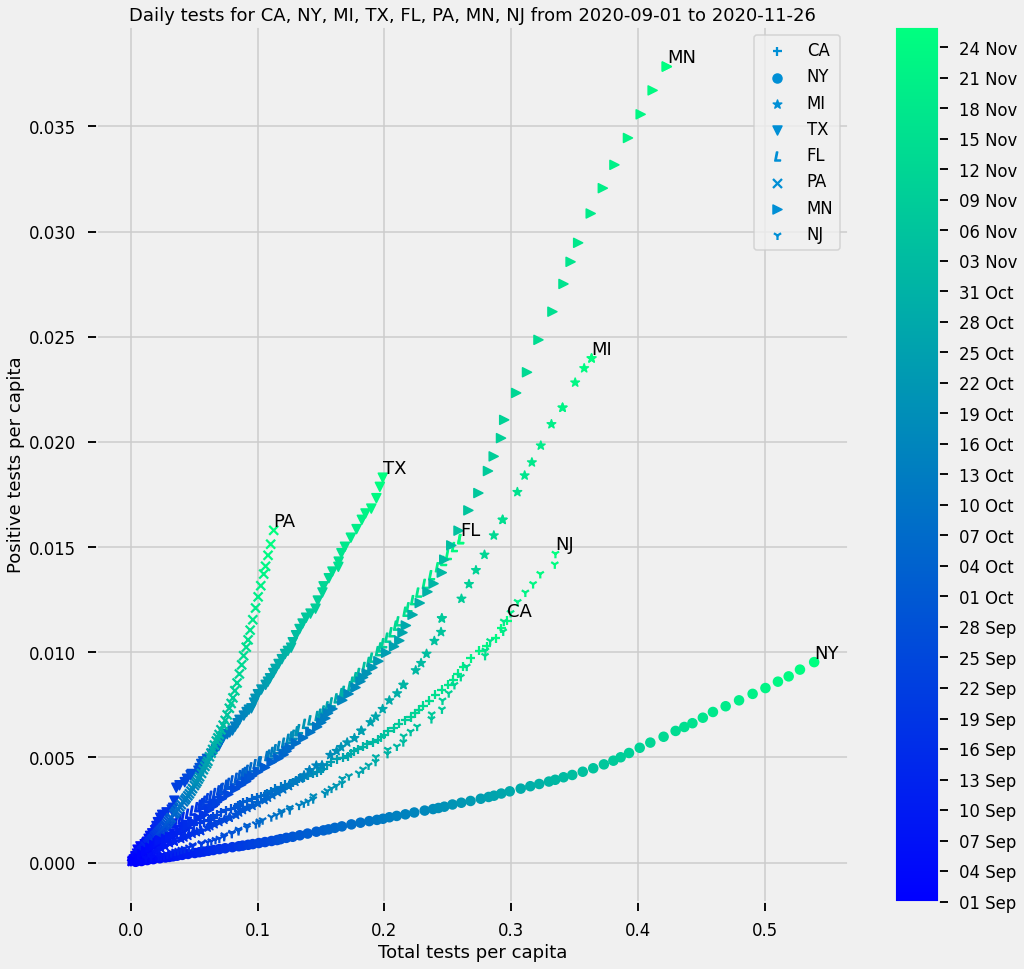

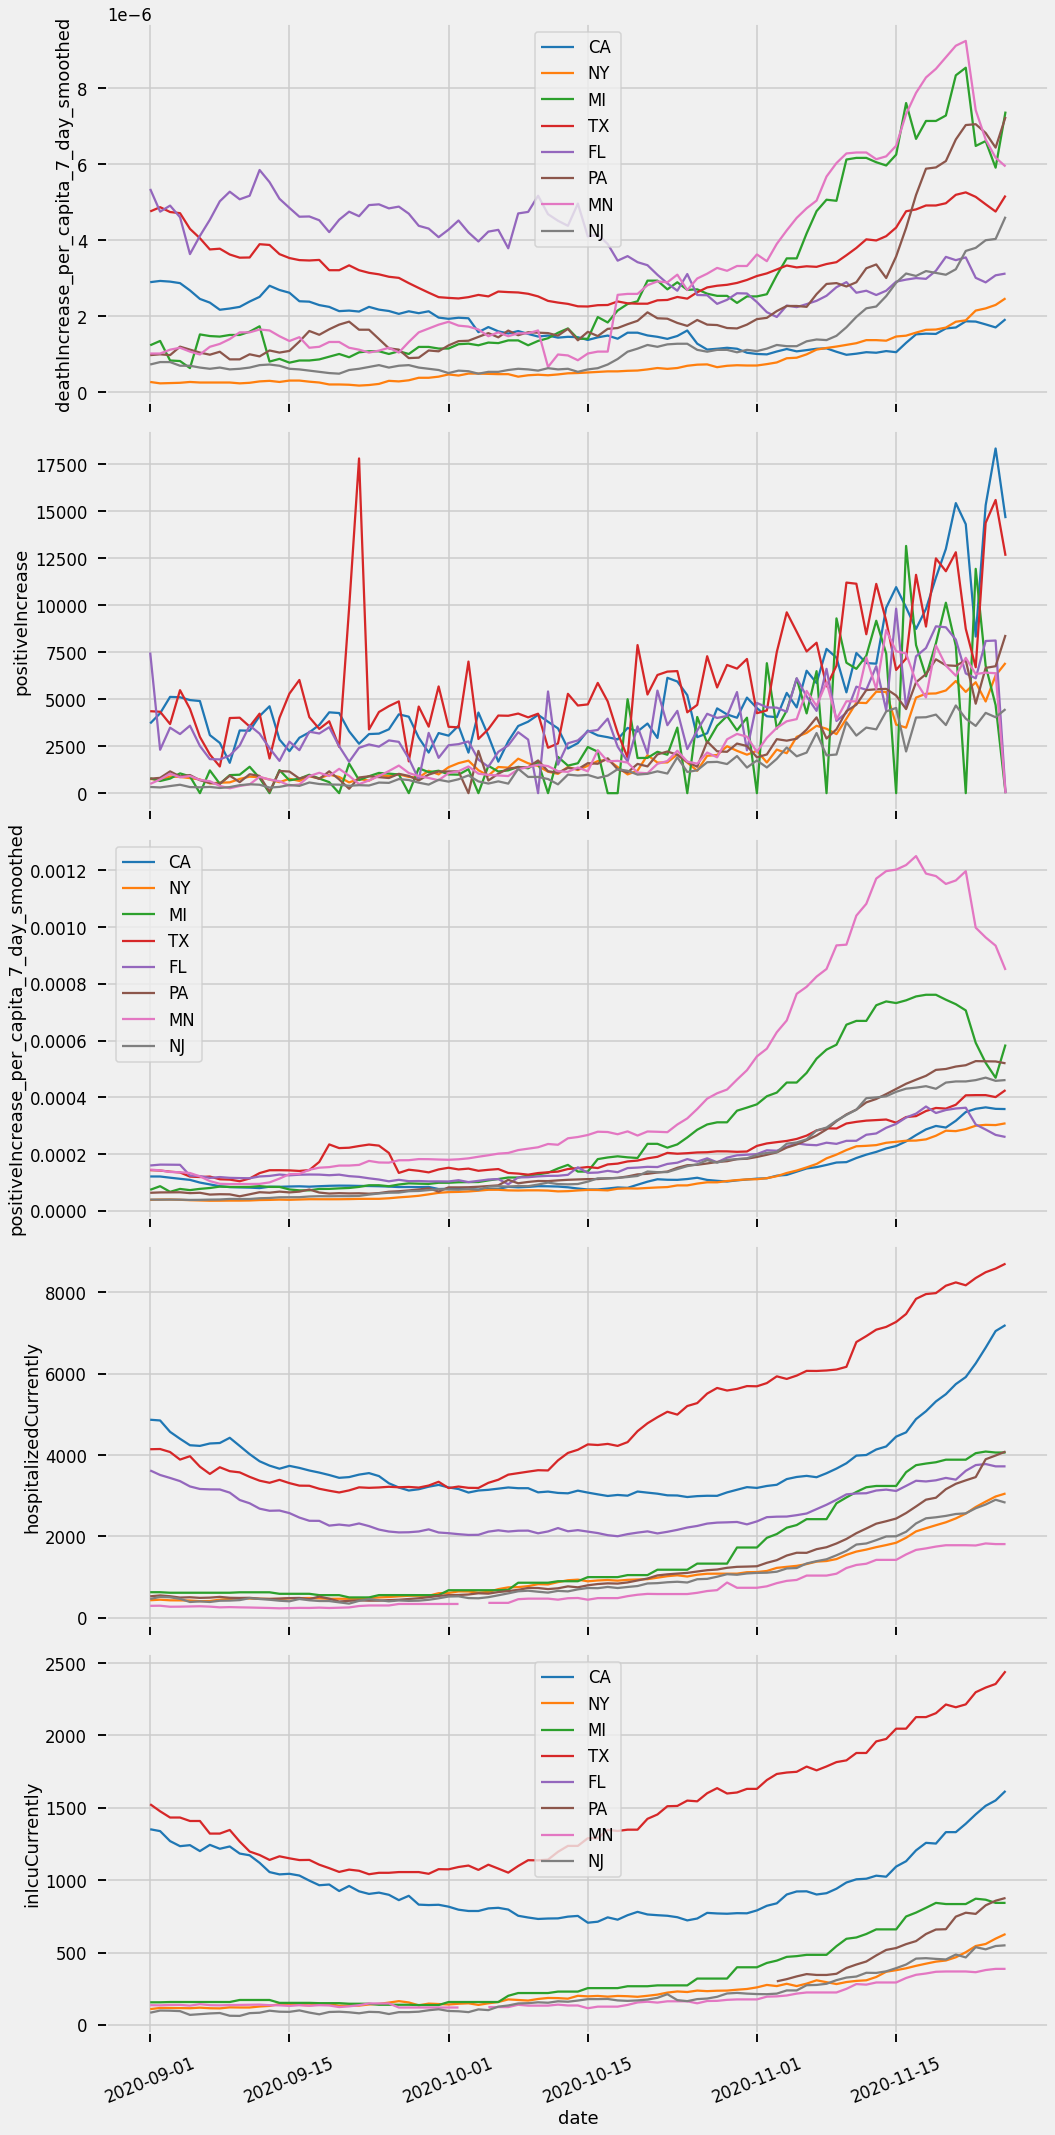

In [28]:
interesting_states = ['CA', 'NY', 'MI', 'TX', 'FL', 'PA', 'MN', 'NJ']
test_rate_plot(recent_states, interesting_states)
test_rate_plot(recent_states, interesting_states, per_capita=True)
better_comparison_plot(recent_states, interesting_states,
                       ['deathIncrease_per_capita_7_day_smoothed',
                        'positiveIncrease', 
                        'positiveIncrease_per_capita_7_day_smoothed',
                        'hospitalizedCurrently',
                        'inIcuCurrently', 
                       ], 
                       plot_log=False)

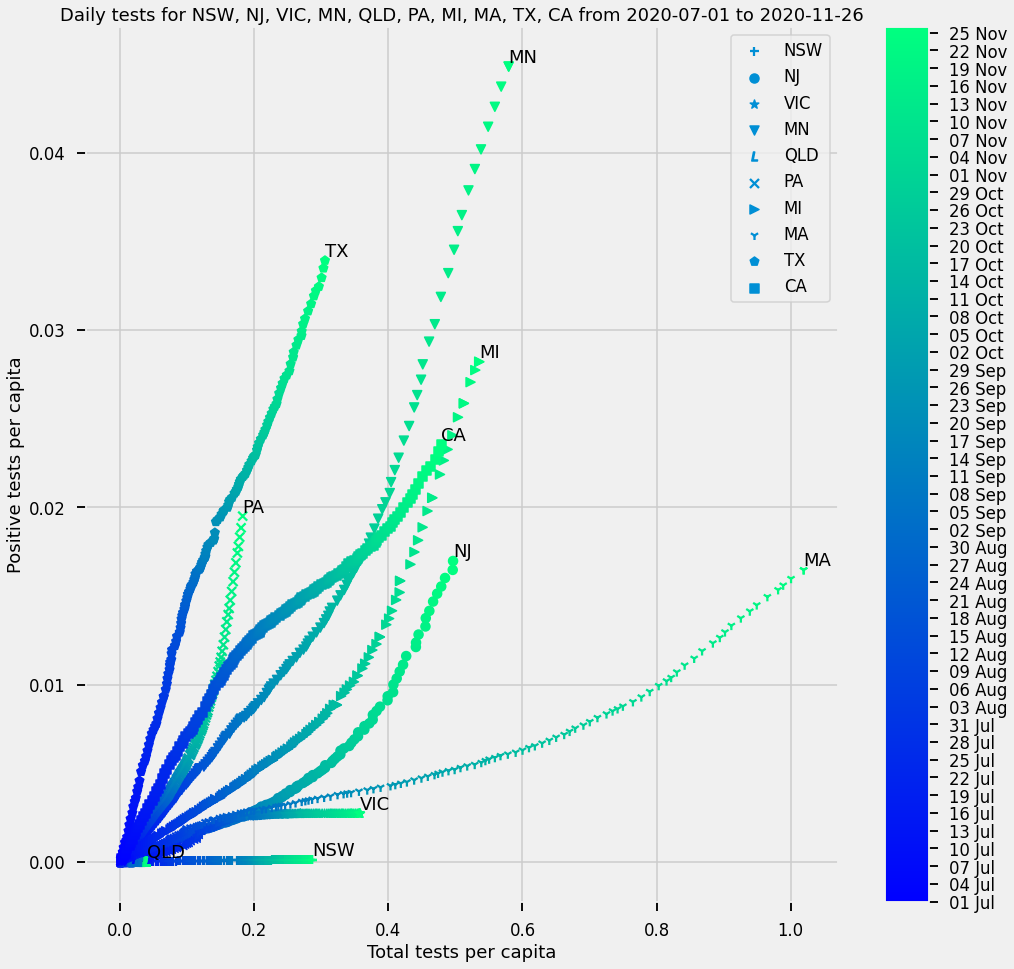

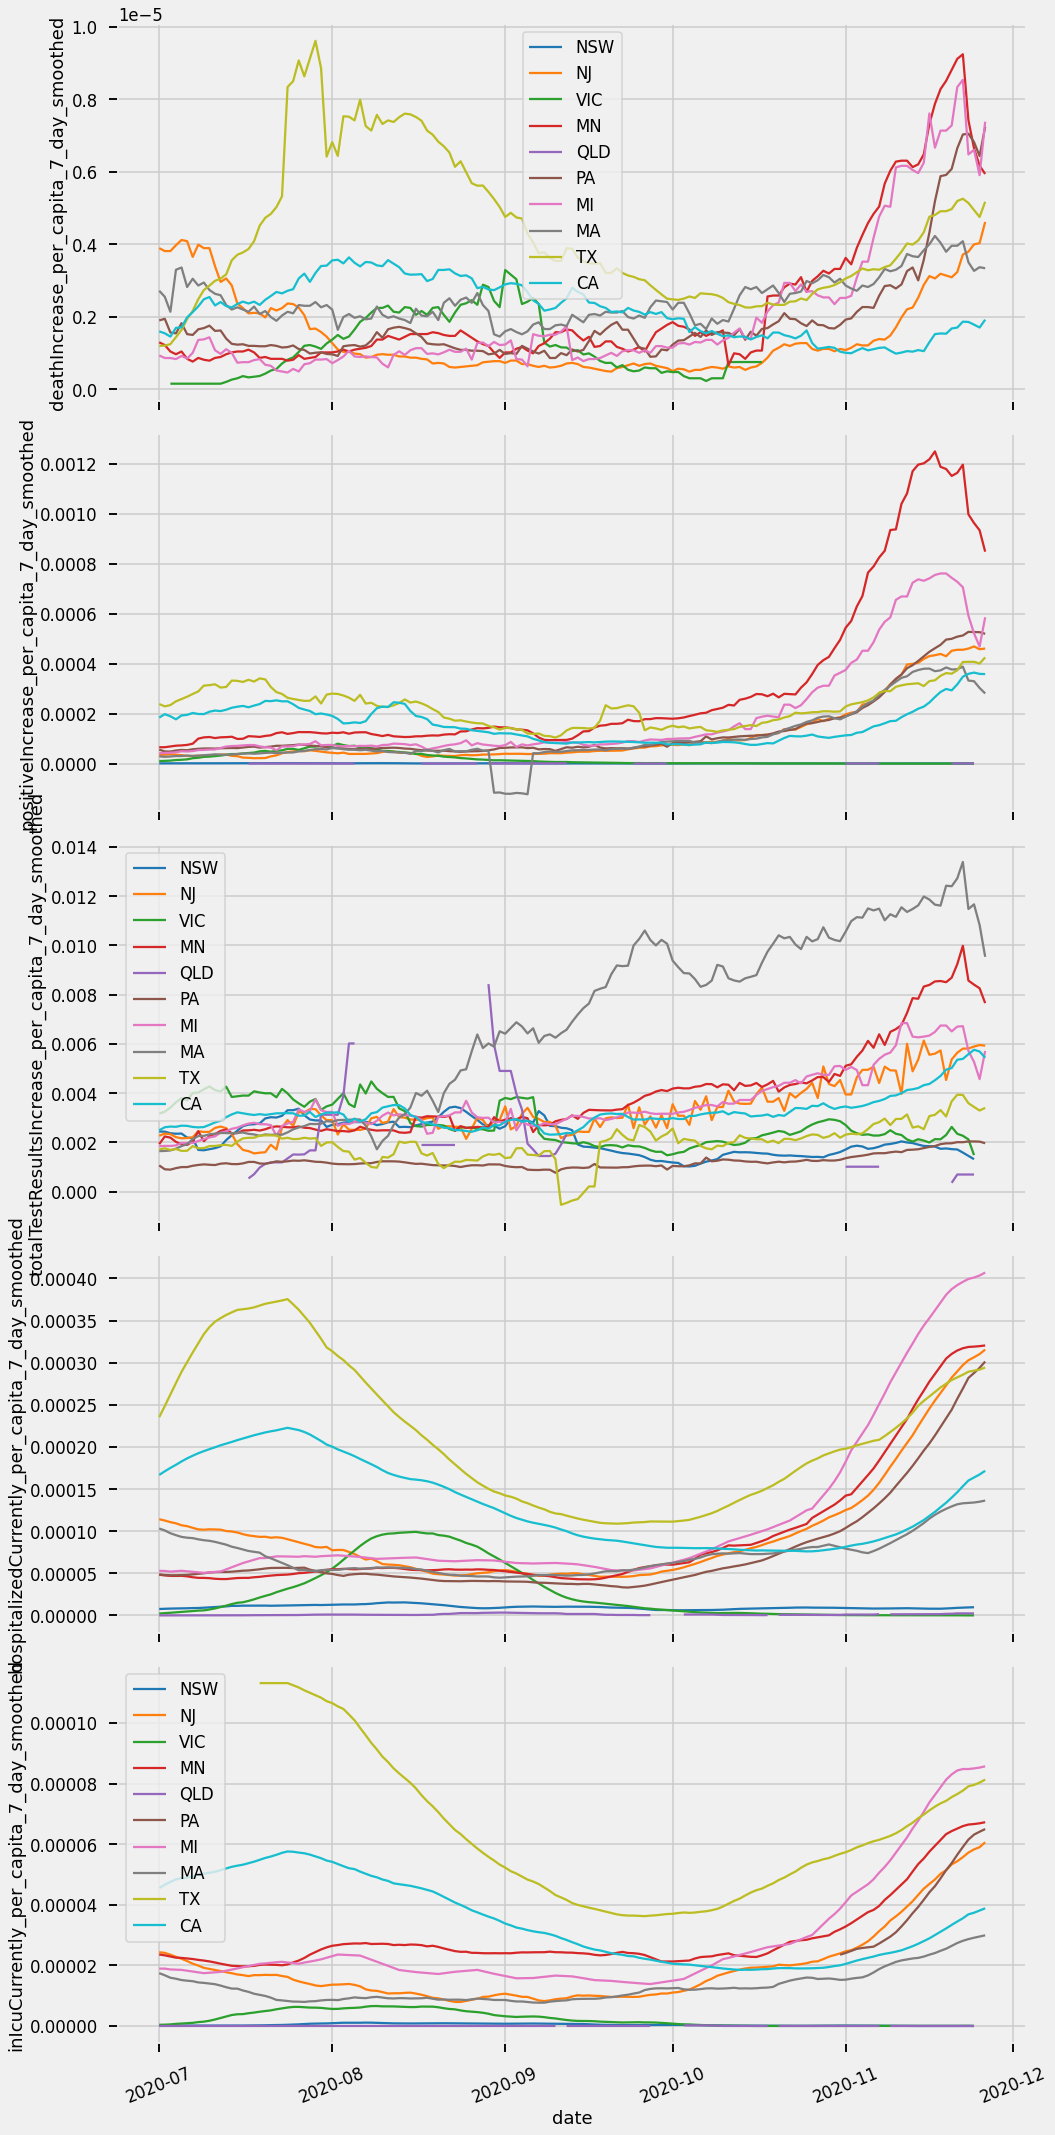

In [29]:
plot_combined_states = ['NSW', 'NJ', 'VIC', 'MN', 'QLD', 'PA', 'MI', 'MA', 'TX', 'CA']
test_rate_plot(combined_recent_states, plot_combined_states, per_capita=True)
better_comparison_plot(combined_recent_states, 
                       plot_combined_states,
                       [f'{v}_per_capita_7_day_smoothed' for v in 
                        ['deathIncrease', 
                         'positiveIncrease',
                         'totalTestResultsIncrease',
                         'hospitalizedCurrently',
                         'inIcuCurrently',
                        ]
                       ], plot_log=False)